In [155]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import os
from progressbar import progressbar as pbar
from earthtext.osm import osm
from joblib import delayed, Parallel
import sys

# gather all areas and lengths of all tags

In [27]:
osm_folder = "/opt/data/california-naip-chips/osm"

In [28]:
osm_files = os.listdir(osm_folder)
len(osm_files)

113160

In [40]:
class mParallel(Parallel):
    """
    substitutes joblib.Parallel with richer verbose progress information
    """
    def _print(self, msg):
        if self.verbose > 10:
            fmsg = '[%s]: %s' % (self, msg)
            sys.stdout.write('\r ' + fmsg)
            sys.stdout.flush()

In [83]:
def get_tag_stats(osm_file):
    tag_stats = {}
    z = gpd.read_parquet(f"{osm_folder}/{osm_file}")
    for _,row in z.iterrows():
        tags = tags if type(row.tags)==dict else eval(row.tags)
        for k,v in tags.items():
            t = f"{k}={v}"
            if not t in tag_stats.keys():
                tag_stats[t] = {'areas': [], 'lengths': []}
            tag_stats[t]['areas'].append(row['area'])
            tag_stats[t]['lengths'].append(row['length'])
    return tag_stats

In [84]:
r = mParallel(n_jobs=60, verbose=30)(delayed(get_tag_stats)(osm_file) for osm_file in osm_files)

 [mParallel(n_jobs=60)]: Done 113160 out of 113160 | elapsed:  1.3min finishedg:    0.1sh_size=8.

In [85]:
len(osm_files)

113160

In [86]:
r[0]

{'highway=track': {'areas': [0.0], 'lengths': [153.6865180999946]},
 'landuse=farmland': {'areas': [18671.535429628813],
  'lengths': [546.9192079617839]}}

In [191]:
consolidated_stats = {}
for ri in pbar(r):
    for k,v in ri.items():
        if not k in consolidated_stats.keys():
            consolidated_stats[k] = {'areas': [], 'lengths': [], 'counts': [] } 

        consolidated_stats[k]['areas'] = consolidated_stats[k]['areas'] + v['areas']
        consolidated_stats[k]['lengths'] = consolidated_stats[k]['lengths'] + v['lengths']
        consolidated_stats[k]['counts'].append(len(v['areas']))

100% (113160 of 113160) |################| Elapsed Time: 0:03:40 Time:  0:03:400218


In [192]:
len(r)

113160

# consider tags that appear in at least 100 chips

In [233]:
keys100 = [k for k in consolidated_stats.keys() if len(consolidated_stats[k]['counts'])>100]

In [235]:
consolidated_stats_k100 = {k:v for k, v in consolidated_stats.items() if k in keys100}
consolidated_stats_k100[

In [264]:
consolidated_stats_k100 = {}
for k, v in consolidated_stats.items():
    if k in keys100:
        consolidated_stats_k100[k] = v
        consolidated_stats_k100[k]['nchips'] = len(consolidated_stats_k100[k]['counts'])


In [271]:
cmeans = {k: {kk:(np.mean(vv) if kk!='nchips' else vv) for kk,vv in v.items()} for k,v in consolidated_stats_k100.items()}

In [278]:
pd.DataFrame(cmeans, index=['mean area', 'mean length', 'mean occurrences per chip', 'number of chips it appears']).T

,mean area,mean length,mean occurrences per chip,number of chips it appears
highway=track,NaN,NaN,NaN,NaN
landuse=farmland,NaN,NaN,NaN,NaN
power=tower,NaN,NaN,NaN,NaN
power=line,NaN,NaN,NaN,NaN
landuse=industrial,NaN,NaN,NaN,NaN
...,...,...,...,...
power=cable,NaN,NaN,NaN,NaN
natural=coastline,NaN,NaN,NaN,NaN
railway=light_rail,NaN,NaN,NaN,NaN
leisure=offroad_driving,NaN,NaN,NaN,NaN


In [286]:
s = pd.DataFrame(cmeans).T
s.columns=['mean area', 'mean length', 'mean occurrences per chip', 'number of chips it appears']
s.sort_index(inplace=True)
s

,mean area,mean length,mean occurrences per chip,number of chips it appears
aerodrome:type=public,19834.251312,558.852163,1.008403,119.0
aerospace:project=deep_space_network,22288.607797,597.125056,1.025597,586.0
aeroway=aerodrome,18395.658409,537.915086,1.032637,766.0
aeroway=apron,9053.262303,391.608342,1.056911,123.0
aeroway=runway,606.818775,135.670343,1.160920,174.0
...,...,...,...,...
waterway=ditch,204.581066,100.899189,1.257143,245.0
waterway=drain,0.064539,83.687807,1.433566,1001.0
waterway=pressurised,0.000000,99.995700,1.296029,277.0
waterway=river,0.000000,116.314065,1.039948,776.0


In [301]:
s.loc['natural=tree']

mean area                       0.000000
mean length                     0.000071
mean occurrences per chip      14.715625
number of chips it appears    640.000000
Name: natural=tree, dtype: float64

In [306]:
s[(s['mean area'] + s['mean length']<1e-3)]

,mean area,mean length,mean occurrences per chip,number of chips it appears
emergency=fire_hydrant,0.0,0.000000,1.569892,186.0
entrance=yes,0.0,0.000000,2.637168,113.0
fire_hydrant:type=pillar,0.0,0.000000,1.527273,110.0
highway=motorway_junction,0.0,0.000000,1.032787,244.0
highway=stop,0.0,0.000000,1.693462,2799.0
highway=street_lamp,0.0,0.000000,6.130435,161.0
highway=traffic_signals,0.0,0.000000,1.688863,1742.0
highway=turning_circle,0.0,0.000000,1.233637,4721.0
highway=turning_loop,0.0,0.000000,1.078740,127.0
leisure=picnic_table,0.0,0.000000,3.600000,145.0


In [312]:
s.shape

(263, 4)

In [316]:
ss = """aeroway=aerodrome
aeroway=apron
aeroway=runway
aeroway=taxiway
amenity=fuel
amenity=hospital
amenity=parking
amenity=school
amenity=university
bridge=yes
building=apartments
building=church
building=commercial
building=detached
building=hotel
building=house
building=industrial
building=residential
building=retail
building=school
building=warehouse
building=yes
bus=yes
crossing=marked
crossing=traffic_signals
footway=crossing
footway=sidewalks
highway=crossing
highway=cycleway
highway=footway
highway=motorway
highway=motorway_junction
highway=path
highway=pedestrian
highway=residential
highway=track
industrial=oil
landuse=cemetary
landuse=commercial
landuse=construction
landuse=farm
landuse=farmland
landuse=farmyard
landuse=forest
landuse=grass
landuse=industrial
landuse=landfill
landuse=meadow
landuse=military
landuse=orchard
landuse=quarry
landuse=railway
landuse=recreation_grounds
landuse=religious
landuse=residential
landuse=retail
leisure=garden
leisure=golf_course
leisure=nature_reserve
leisure=park
leisure=pitch
leisure=playground
leisure=sports_centre
leisure=swimming_pool
natural=bare_rock
natural=coastline
natural=desert
natural=grassland
natural=heath
natural=hill
natural=mud
natural=sand
natural=scree
natural=scrub
natural=tree
natural=tree_row
natural=valley
natural=water
natural=wetland
natural=wood
parking=surface
place=city
place=village
power=generator
power=plant
power=substation
power=tower
public_transport=platform
railway=light_rail
railway=rail
reservoir_type=water_storage
residential=apartments
residential=trailer_park
sport=baseball
sport=basketball
sport=soccer
sport=tennis
surface=asphalt
surface=concrete
surface=dirt
surface=grass
surface=gravel
surface=paved
surface=sand
tourism=camp_site
tourism=hotel
tourism=motel
tunnel=yes
water=basin
water=canal
water=lake
water=pond
water=reservoir
water=river
water=stream
water=canal
waterway=river
waterway=stream"""

In [320]:
r = {}
for ssi in ss.split():
    k,v = ssi.split("=")
    if not k in r.keys():
        r[k]= []
    r[k].append(v)

In [327]:
len(r) + 118

143

In [324]:
for k,v in r.items():
    print (f"raw_osm_keyvals['{k}'] = {v}")

raw_osm_keyvals['aeroway'] = ['aerodrome', 'apron', 'runway', 'taxiway']
raw_osm_keyvals['amenity'] = ['fuel', 'hospital', 'parking', 'school', 'university']
raw_osm_keyvals['bridge'] = ['yes']
raw_osm_keyvals['building'] = ['apartments', 'church', 'commercial', 'detached', 'hotel', 'house', 'industrial', 'residential', 'retail', 'school', 'warehouse', 'yes']
raw_osm_keyvals['bus'] = ['yes']
raw_osm_keyvals['crossing'] = ['marked', 'traffic_signals']
raw_osm_keyvals['footway'] = ['crossing', 'sidewalks']
raw_osm_keyvals['highway'] = ['crossing', 'cycleway', 'footway', 'motorway', 'motorway_junction', 'path', 'pedestrian', 'residential', 'track']
raw_osm_keyvals['industrial'] = ['oil']
raw_osm_keyvals['landuse'] = ['cemetary', 'commercial', 'construction', 'farm', 'farmland', 'farmyard', 'forest', 'grass', 'industrial', 'landfill', 'meadow', 'military', 'orchard', 'quarry', 'railway', 'recreation_grounds', 'religious', 'residential', 'retail']
raw_osm_keyvals['leisure'] = ['garden', 'go

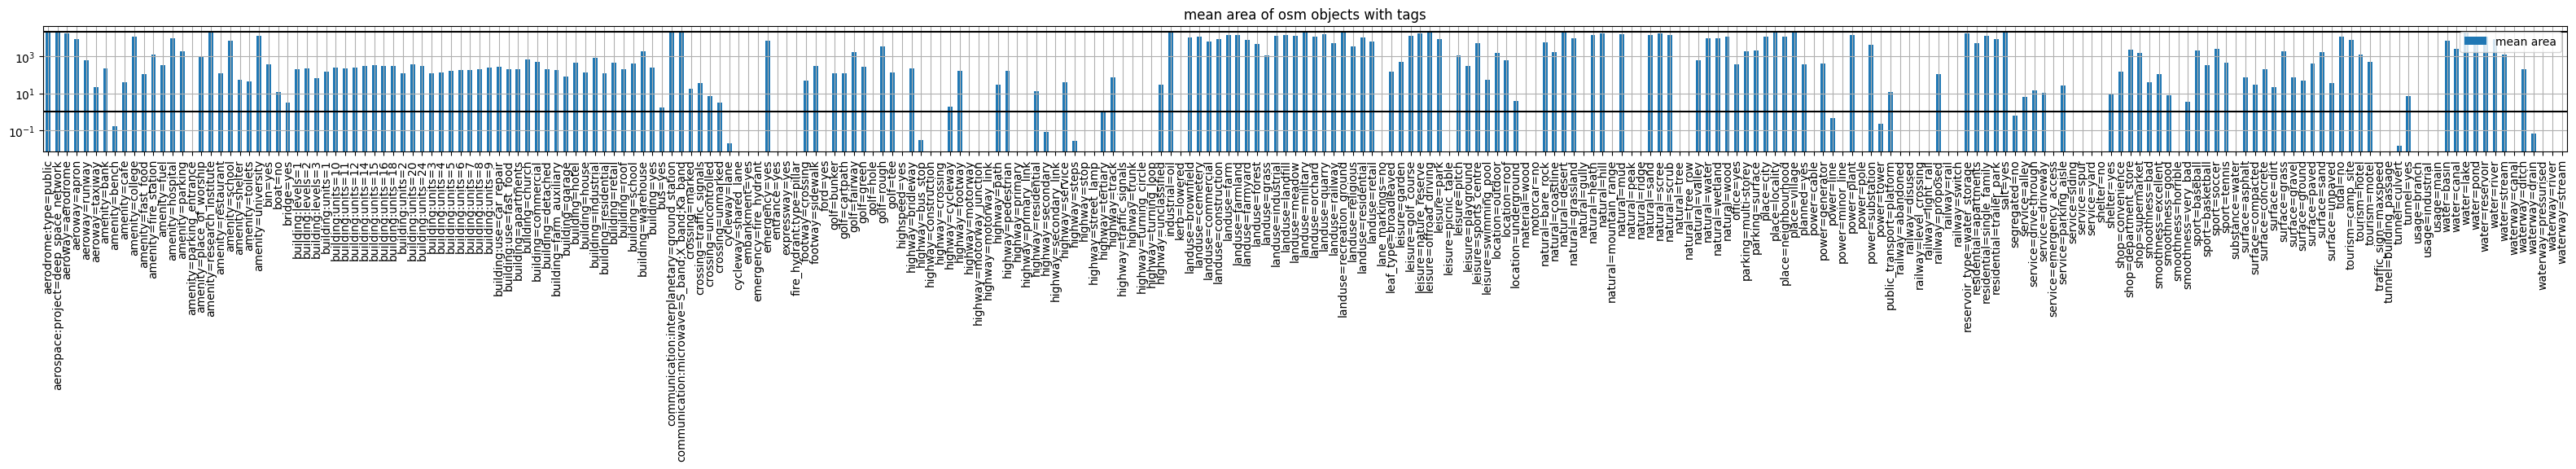

In [300]:
s[['mean area']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean area of osm objects with tags')
plt.axhline(1, color='black')
plt.axhline(22500, color='black')
plt.yscale('log')


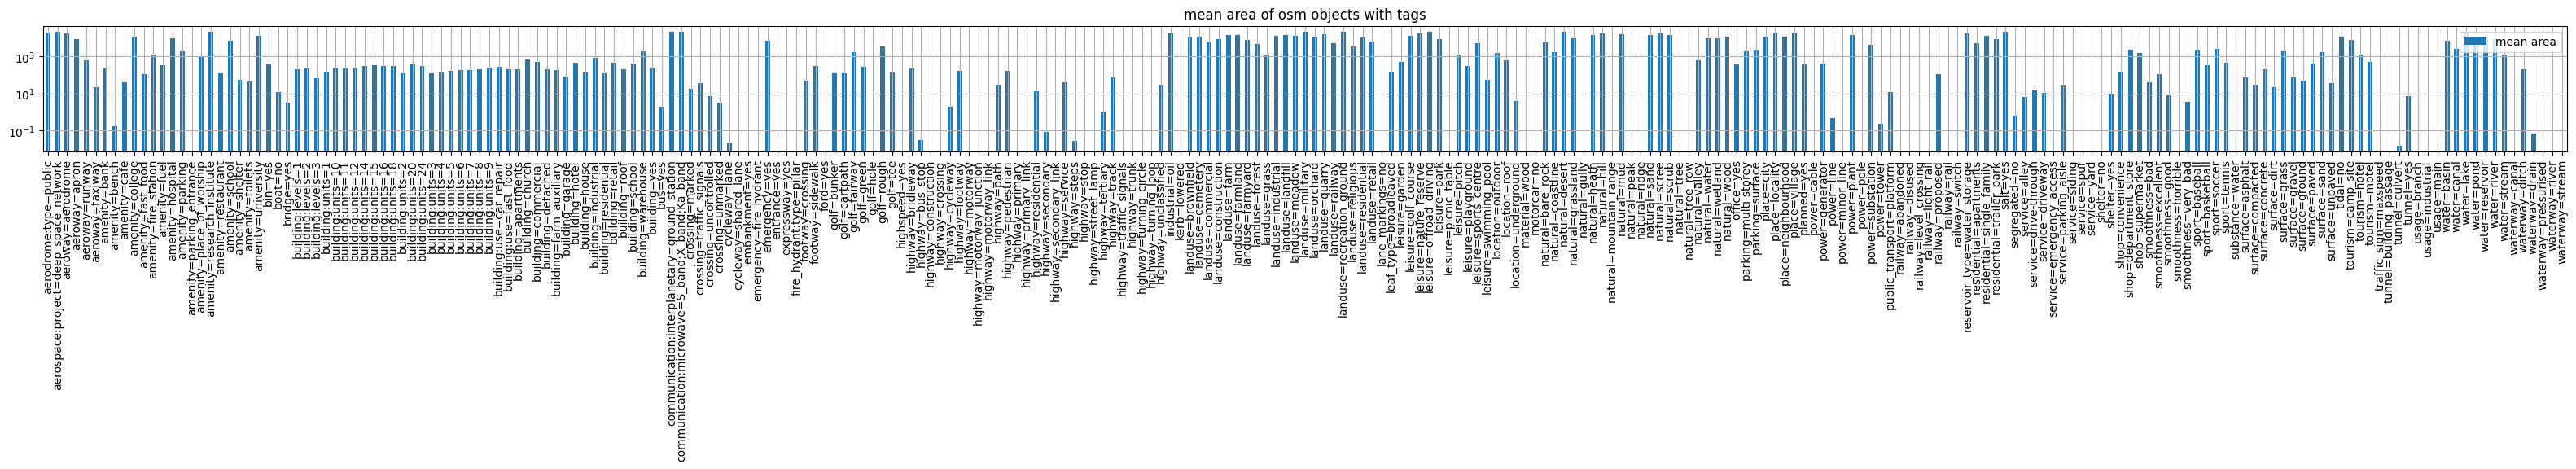

In [291]:
s[['mean area']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean area of osm objects with tags')
plt.yscale('log')


Text(0.5, 1.0, 'mean length of osm objects with tags')

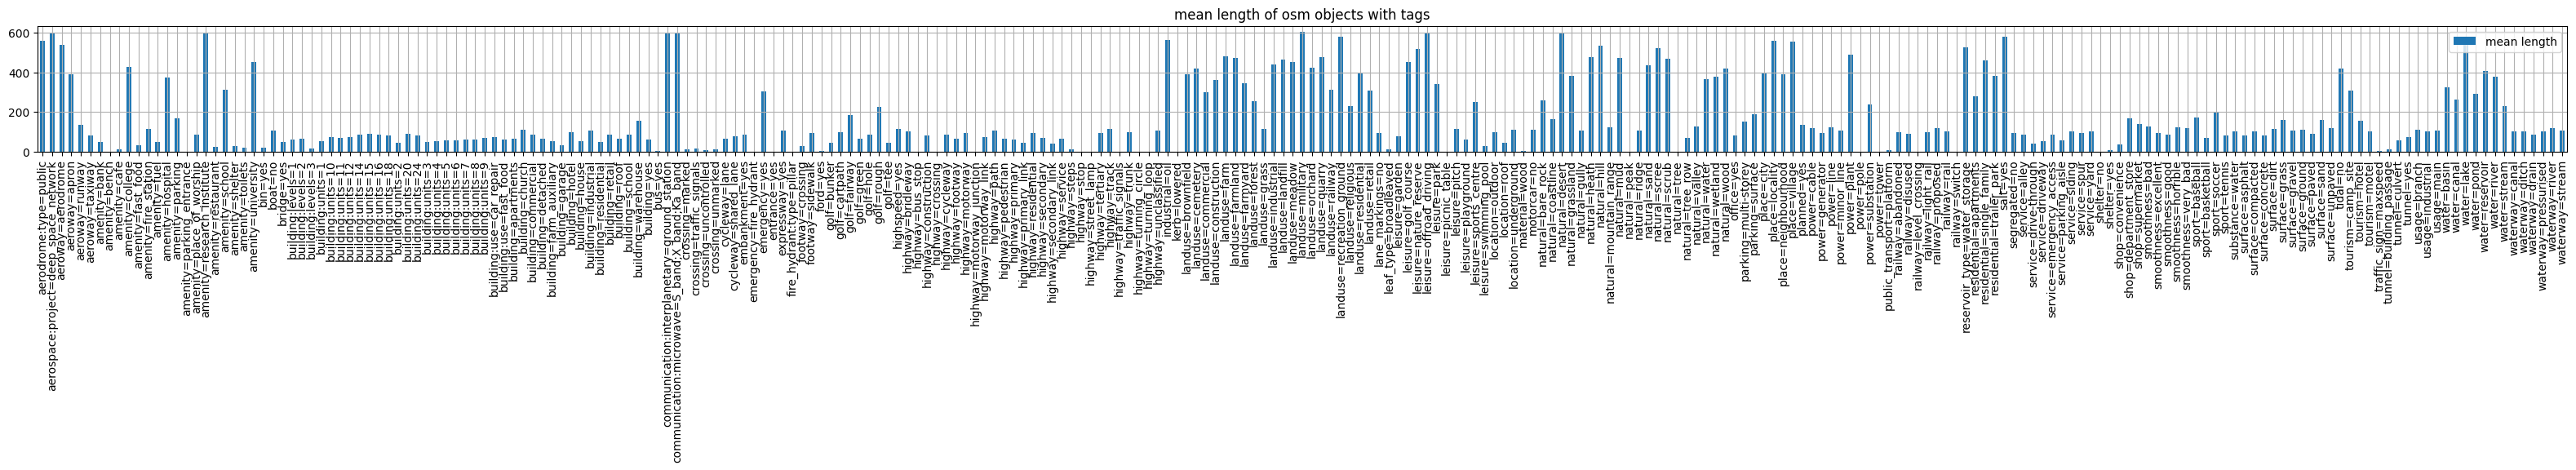

In [297]:
s[['mean length']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean length of osm objects with tags')


Text(0.5, 1.0, 'mean occurrences per chip')

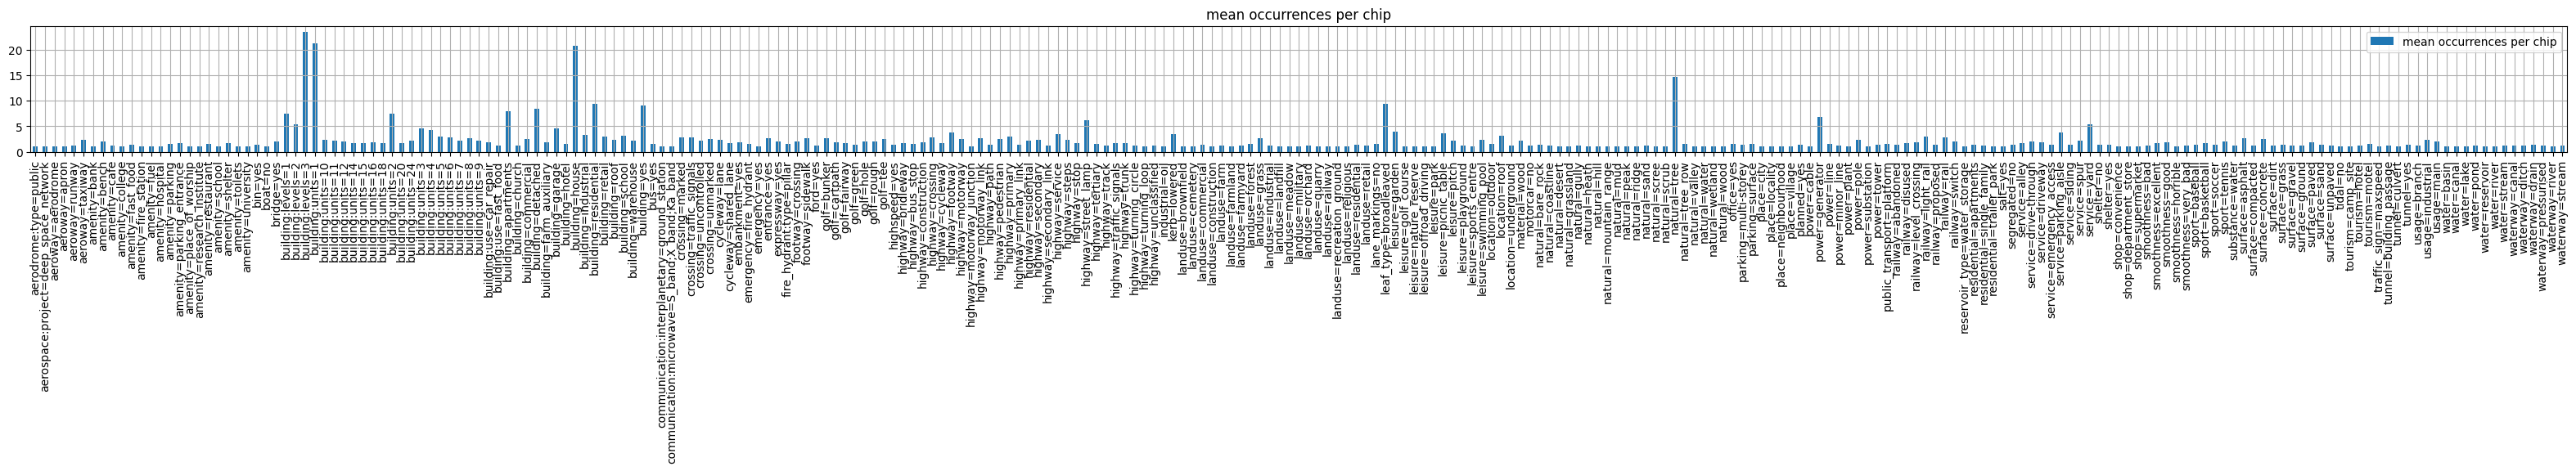

In [293]:
s[['mean occurrences per chip']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean occurrences per chip')

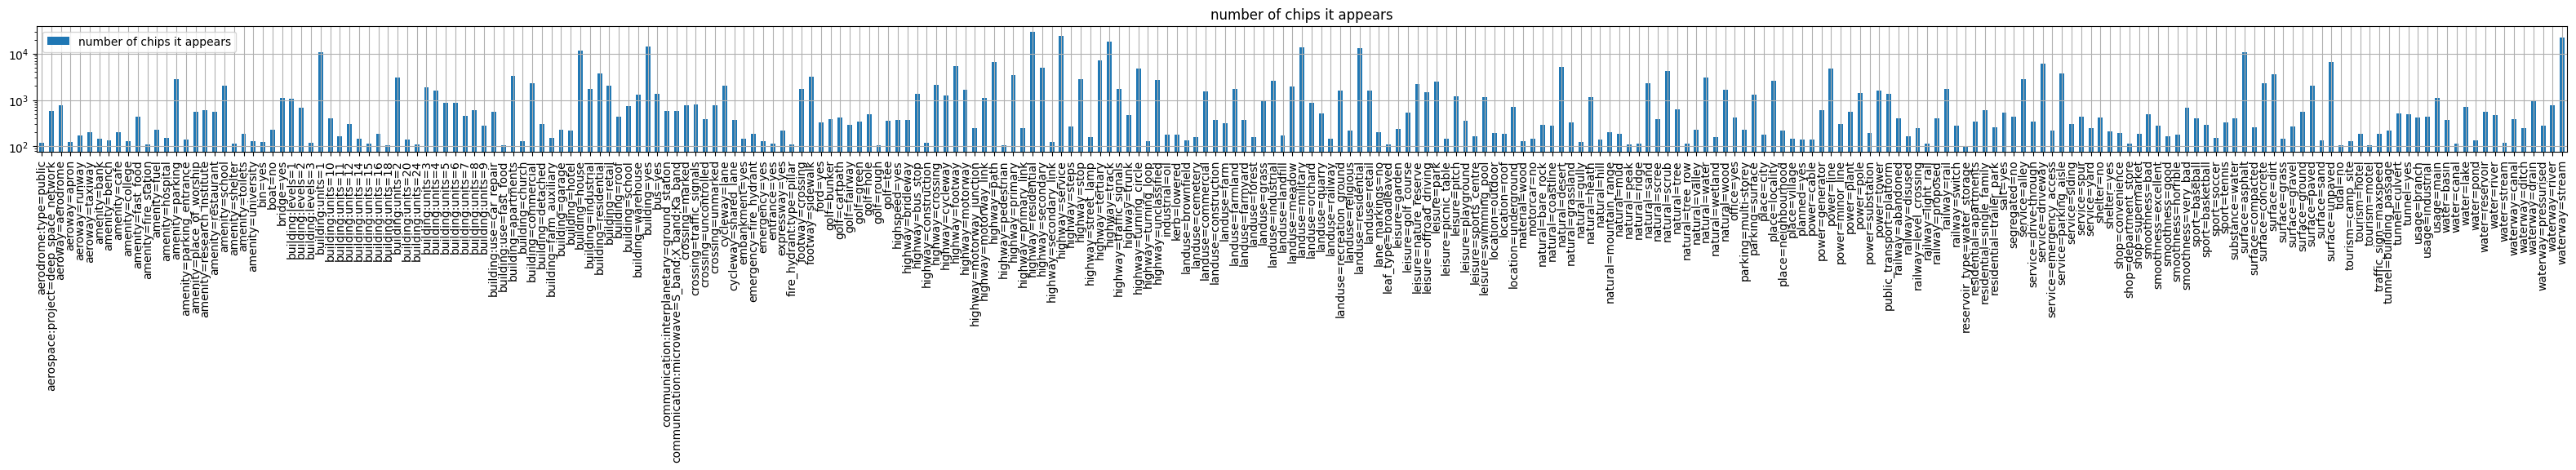

In [295]:
s[['number of chips it appears']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('number of chips it appears')
plt.yscale('log')


In [308]:
c = gpd.read_parquet("/opt/data/california-naip-chips/osm/110015f9589eb.parquet")
c.explore()

In [309]:
c

,tags,geometry,kind,length,area,stags,chip_id
123397461,{'highway': 'stop'},POINT (-118.79757 34.01713),node,0.000000,0.000000,highway: stop,110015f9589eb
3694092271,{'highway': 'turning_loop'},POINT (-118.79711 34.01732),node,0.000000,0.000000,highway: turning_loop,110015f9589eb
11068731634,{'traffic_sign': 'stop'},POINT (-118.79744 34.01708),node,0.000000,0.000000,traffic_sign: stop,110015f9589eb
479,"{'highway': 'residential', 'surface': 'asphalt'}","LINESTRING (-118.79786 34.01746, -118.79781 34...",way,183.545353,0.000000,highway: residential\n<br>\nsurface: asphalt,110015f9589eb
1427,{'highway': 'service'},"LINESTRING (-118.79761 34.01718, -118.79783 34...",way,70.175244,0.000000,highway: service,110015f9589eb
1437,{'highway': 'service'},"LINESTRING (-118.79739 34.01694, -118.79722 34...",way,70.177818,0.000000,highway: service,110015f9589eb
6455,"{'highway': 'service', 'surface': 'compacted'}","MULTILINESTRING ((-118.79698 34.01717, -118.79...",way,59.871104,0.000000,highway: service\n<br>\nsurface: compacted,110015f9589eb
6492,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79806 34.01745, -118.79806 34.0...",way,62.294824,138.169748,building: house\n<br>\nbuilding:units: 1,110015f9589eb
6510,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79710 34.01610, -118.79717 34.0...",way,47.591106,101.418675,building: house\n<br>\nbuilding:units: 1,110015f9589eb
6894,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79761 34.01670, -118.79754 34.0...",way,71.577268,251.442034,building: house\n<br>\nbuilding:units: 1,110015f9589eb
